In [2]:
import os, sys

import numpy as np
import pandas as pd

import anndata
import scanpy as sc
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [3]:
path = '/Users/busracagirici/Documents/scrnaseq/citeseq/'
save_tables = '/Users/busracagirici/Documents/scrnaseq/citeseq/tables/'
save_figures = '/Users/busracagirici/Documents/scrnaseq/citeseq/figures/'


In [2]:
df_kid = pd.read_csv(save_tables+'DEGs_SD_vs_D_medpair_raw_adata_kid.csv', sep='\t', index_col=['cell_type', 'SD', 'D'])
df_kid = df_kid.groupby(['cell_type']).median()
df_adult = pd.read_csv(save_tables+'DEGs_SD_vs_D_medpair_raw.csv', sep='\t', index_col=['cell_type', 'SD', 'D'])
df_adult = df_adult.groupby(['cell_type']).median()

cols = [x for x in df_kid.columns if x in df_adult]
df_kid = df_kid[cols]
df_kid = df_kid.reset_index().melt(id_vars='cell_type').set_index('cell_type')
df_kid.columns = ['gene', 'adata_kid']
df_kid = df_kid.reset_index().set_index(['cell_type', 'gene'])

df_adult = df_adult[cols]
df_adult = df_adult.reset_index().melt(id_vars='cell_type').set_index('cell_type')
df_adult.columns = ['gene', 'adata_adult']
df_adult = df_adult.reset_index().set_index(['cell_type', 'gene'])


In [3]:
all_stats2 = pd.concat([df_kid, df_adult], axis=1)
all_stats2

,,adata_kid,adata_adult
cell_type,gene,,
B cells,A1BG,0.069665,0.093002
Monocytes,A1BG,0.254801,-0.104599
NK cells,A1BG,0.136194,-0.019719
Plasmablasts,A1BG,0.338334,-0.290389
T cells,A1BG,0.082524,-0.062667
...,...,...,...
Monocytes,ZZEF1,0.014514,0.296190
NK cells,ZZEF1,0.045093,-0.209797
Plasmablasts,ZZEF1,0.138119,0.180561


In [4]:
ct= 'Monocytes'

sc_col='adata_kid'
cy_col='adata_adult'
all_stats2['DEG'] = 'no'
all_stats2.loc[all_stats2[(all_stats2[sc_col] > 1) | (all_stats2[cy_col] > 1)].index, 'DEG'] = 'upregulated_either'
all_stats2.loc[all_stats2[(all_stats2[sc_col] > 1) & (all_stats2[cy_col] > 1)].index, 'DEG'] = 'upregulated_both'
all_stats2.loc[all_stats2[(all_stats2[sc_col] < -1) | (all_stats2[cy_col] < -1)].index, 'DEG'] = 'downregulated_either'
all_stats2.loc[all_stats2[(all_stats2[sc_col] < -1) & (all_stats2[cy_col] < -1)].index, 'DEG'] = 'downregulated_both'
all_stats2.loc[all_stats2[(all_stats2[sc_col] < -1) & (all_stats2[cy_col] > 1)].index, 'DEG'] = 'reverse'
all_stats2.loc[all_stats2[(all_stats2[sc_col] > 1) & (all_stats2[cy_col] < -1)].index, 'DEG'] = 'reverse'
#all_stats2 = all_stats2.loc[ct]
all_stats2

,,adata_kid,adata_adult,DEG
cell_type,gene,,,
B cells,A1BG,0.069665,0.093002,no
Monocytes,A1BG,0.254801,-0.104599,no
NK cells,A1BG,0.136194,-0.019719,no
Plasmablasts,A1BG,0.338334,-0.290389,no
T cells,A1BG,0.082524,-0.062667,no
...,...,...,...,...
Monocytes,ZZEF1,0.014514,0.296190,no
NK cells,ZZEF1,0.045093,-0.209797,no
Plasmablasts,ZZEF1,0.138119,0.180561,no


In [5]:
all_stats2['r'] = (all_stats2['adata_adult']**2 + all_stats2['adata_kid']**2)**0.5
all_stats2['r2'] = all_stats2['adata_adult']**2 + all_stats2['adata_kid']**2
all_stats2['distance'] = abs(all_stats2['adata_adult'] - all_stats2['adata_kid']) / (2**0.5)
all_stats2

,,adata_kid,adata_adult,DEG,r,r2,distance
cell_type,gene,,,,,,
B cells,A1BG,0.069665,0.093002,no,0.116201,0.013503,0.016502
Monocytes,A1BG,0.254801,-0.104599,no,0.275435,0.075864,0.254134
NK cells,A1BG,0.136194,-0.019719,no,0.137614,0.018938,0.110247
Plasmablasts,A1BG,0.338334,-0.290389,no,0.445865,0.198796,0.444575
T cells,A1BG,0.082524,-0.062667,no,0.103621,0.010737,0.102665
...,...,...,...,...,...,...,...
Monocytes,ZZEF1,0.014514,0.296190,no,0.296545,0.087939,0.199175
NK cells,ZZEF1,0.045093,-0.209797,no,0.214588,0.046048,0.180234
Plasmablasts,ZZEF1,0.138119,0.180561,no,0.227330,0.051679,0.030011


In [6]:
all_stats2 = all_stats2.sort_values(by=['DEG', 'adata_adult'], ascending=False)
all_stats2

adata_kid  adata_adult                 DEG         r  \
cell_type    gene                                                            
cDCs         IFI44L   -0.019448     4.687411  upregulated_either  4.687452   
             MX1       0.786045     3.613609  upregulated_either  3.698113   
Monocytes    IFI6      0.433512     3.268317  upregulated_either  3.296942   
Plasmablasts XIST      0.739080     3.064833  upregulated_either  3.152687   
cDCs         ISG15     0.483966     2.775574  upregulated_either  2.817452   
...                         ...          ...                 ...       ...   
T cells      MT-ND3   -1.408136    -2.633475  downregulated_both  2.986309   
NK cells     MT-ATP8  -1.669241    -2.687243  downregulated_both  3.163486   
             MT-ND3   -1.699584    -2.887828  downregulated_both  3.350842   
cDCs         MT-ATP8  -2.953710    -3.000147  downregulated_both  4.210141   
Plasmablasts PTPRCAP  -2.122727    -3.088868  downregulated_both  3.747943   

                             r2  distance  
cell_type    gene                          
cDCs         IFI44L   21.972203  3.328252  
             MX1      13.676040  1.999390  
Monocytes    IFI6     10.869826  2.004509  
Plasmablasts XIST      9.939438  1.644556  
cDCs         ISG15     7.938036  1.620412  
...                         ...       ...  
T cells      MT-ND3    8.918040  0.866445  
NK cells     MT-ATP8  10.007641  0.719836  
             MT-ND3   11.228139  0.840216  
cDCs         MT-ATP8  17.725289  0.032836  
Plasmablasts PTPRCAP  14.047077  0.683165  

[124560 rows x 6 columns]

In [28]:
sns.color_palette("tab10")

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [29]:
genes = ['BANF1', 'IRF1', 'STAT1', 
         'IFIT1', 'ISG15', 'APOBEC3A', 'MX1', 'IFITM1', 'IFI44L',  'IFI6'
        ]



In [59]:
import textalloc as ta
from adjustText import adjust_text

def plot_scatter_allcts(all_stats2, cts=['NK cells'], figsize=[5.4, 3.6], genes=genes):
    import matplotlib as mpl
    from matplotlib.patches import Ellipse
    sc_col='adata_kid'
    cy_col='adata_adult'

    title = 'Severe dengue vs Dengue'
    fig, ax = plt.subplots(figsize=figsize)
    hue_order=['upregulated_both', 'upregulated_either', 'reverse', 'no', 'downregulated_either', 'downregulated_both']
    palette=sns.color_palette('RdBu')[:1]+ ['gray', 'gray', 'gray', 'gray'] + sns.color_palette('RdBu')[-1:]
    hue_order=['upregulated_both', 'downregulated_both', 'upregulated_either', 'no', 'downregulated_either', 'reverse', ]
    palette=sns.color_palette('RdBu')[:1]+ sns.color_palette('RdBu')[:1] + ['gray', 'gray', 'gray'] + sns.color_palette('RdBu')[-1:]
    palette=['orange', 'orange', 'gray', 'gray', 'gray', 'orange']

    markers = {'B cells': '.', 'cDCs': 'v', 'Monocytes': 's', 'NK cells': 'o', 'T cells': '^', 'Plasmablasts': '*'}
#all_poss=['.','o','v','^','>','<','s','p','*','h','H','D','d','1','','']

    all_stats = all_stats2.reset_index().set_index(['gene'])
    all_stats = all_stats.loc[genes]
    all_stats['size'] = [10 if x == 'no' else 30 for x in all_stats.DEG]
    #df=all_stats.reset_index().set_index(['gene'])
    df=all_stats.reset_index().set_index(['gene', 'cell_type'])
    
    df['genes'] = list(df.reset_index()['gene'])
    

    sns.scatterplot(data=df, x=sc_col, y=cy_col, ax=ax, hue='genes', 
                #hue_order=hue_order,
                style = 'cell_type', 
                    markers= markers, size = 50,
                palette=sns.color_palette("tab10"), 
                edgecolor='none', s=3)
        
    h, l = ax.get_legend_handles_labels()
    #ax.legend(h[-5:], l[-5:], bbox_to_anchor=(1, 1))
    ax.legend(h[-5:], l[-5:], bbox_to_anchor=(1., 1)).set_title('Cell Types')
    #('IGHG2', 'Monocytes')
    #ta.allocate(ax,df[sc_col][genes],df[cy_col][genes], genes,
    #        x_scatter=df[sc_col], y_scatter=df[cy_col], textsize=10, linecolor='orange')
    
    genes = df[df.DEG.isin(['upregulated_both','downregulated_both', 'reverse'])].index.to_list()
    for gene in genes:
        ax.text(df[sc_col][gene]+0., df[cy_col][gene]-0.3, gene[0], ha='center', va='bottom', size='x-small')



    ax.grid(True)
    ax.set_xlabel('log2 fold change (SDp vs D)\n in children')
    ax.set_ylabel('log2 fold change (SDp vs D)\n in adults')
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    lim = max(abs(xmin), abs(xmax), abs(ymin), abs(ymax))

    ax.set_xlim(-1*lim, lim)
    ax.set_xticks(range(-1*int(lim),int(lim)+1,1))
    ax.set_ylim(-1*lim, lim)
    ax.set_yticks(range(-1*int(lim),int(lim)+1,1))
    
    ax.axhline(y = 1, xmin=0, xmax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
    ax.axhline(y = -1, xmin=0, xmax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
    ax.axhline(y = 1, xmin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
    ax.axhline(y = -1, xmin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
    ax.axvline(x = 1, ymin=0, ymax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
    ax.axvline(x = -1, ymax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
    ax.axvline(x = 1, ymin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
    ax.axvline(x = -1, ymin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)

    #ax.set_title(ct)
    #ax.get_legend().remove()
    ax.legend(bbox_to_anchor=(1, 1))
    fig.tight_layout()
#    plt.savefig(save_figures + f'adults_vs_children_scatterplots_{ct}.svg')
    plt.show()
    return(fig, ax)

In [60]:
all_stats2

adata_kid  adata_adult                 DEG         r  \
cell_type    gene                                                            
cDCs         IFI44L   -0.019448     4.687411  upregulated_either  4.687452   
             MX1       0.786045     3.613609  upregulated_either  3.698113   
Monocytes    IFI6      0.433512     3.268317  upregulated_either  3.296942   
Plasmablasts XIST      0.739080     3.064833  upregulated_either  3.152687   
cDCs         ISG15     0.483966     2.775574  upregulated_either  2.817452   
...                         ...          ...                 ...       ...   
T cells      MT-ND3   -1.408136    -2.633475  downregulated_both  2.986309   
NK cells     MT-ATP8  -1.669241    -2.687243  downregulated_both  3.163486   
             MT-ND3   -1.699584    -2.887828  downregulated_both  3.350842   
cDCs         MT-ATP8  -2.953710    -3.000147  downregulated_both  4.210141   
Plasmablasts PTPRCAP  -2.122727    -3.088868  downregulated_both  3.747943   

                             r2  distance  
cell_type    gene                          
cDCs         IFI44L   21.972203  3.328252  
             MX1      13.676040  1.999390  
Monocytes    IFI6     10.869826  2.004509  
Plasmablasts XIST      9.939438  1.644556  
cDCs         ISG15     7.938036  1.620412  
...                         ...       ...  
T cells      MT-ND3    8.918040  0.866445  
NK cells     MT-ATP8  10.007641  0.719836  
             MT-ND3   11.228139  0.840216  
cDCs         MT-ATP8  17.725289  0.032836  
Plasmablasts PTPRCAP  14.047077  0.683165  

[124560 rows x 6 columns]

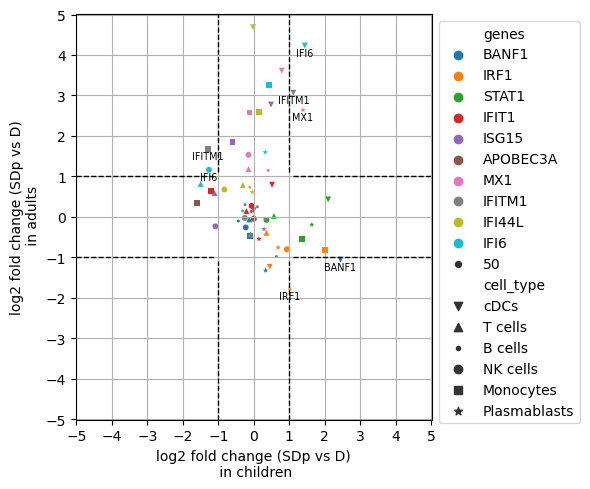

In [63]:
fig, ax = plot_scatter_allcts(all_stats2, cts=['B cells', 'cDCs', 'Monocytes', 'NK cells', 'T cells'], 
                              figsize=[6,5])



In [45]:
all_stats = all_stats2.reset_index().set_index(['gene'])
all_stats = all_stats.loc[genes]
all_stats['size'] = [10 if x == 'no' else 30 for x in all_stats.DEG]
df=all_stats.reset_index().set_index(['gene', 'cell_type'])
df['genes'] = list(df.reset_index()['gene'])
df



adata_kid  adata_adult                   DEG         r  \
gene     cell_type                                                              
BANF1    cDCs           2.440438    -1.060062               reverse  2.660727   
         T cells       -0.127047    -0.064897                    no  0.142662   
         B cells       -0.435524    -0.104498                    no  0.447885   
         NK cells      -0.228882    -0.263110                    no  0.348731   
         Monocytes     -0.102854    -0.480578                    no  0.491461   
         Plasmablasts   0.332001    -1.327533  downregulated_either  1.368419   
IRF1     Monocytes      2.003680    -0.822122    upregulated_either  2.165784   
         B cells        1.014186    -1.787318               reverse  2.055013   
         T cells        0.354291    -0.396033                    no  0.531380   
         Plasmablasts   0.681348    -0.758835                    no  1.019836   
         NK cells       0.930664    -0.800901                    no  1.227834   
         cDCs           0.447901    -1.235842  downregulated_either  1.314504   
STAT1    cDCs           2.092521     0.431378    upregulated_either  2.136523   
         Plasmablasts   1.634691    -0.195099    upregulated_either  1.646292   
         Monocytes      1.365387    -0.538060    upregulated_either  1.467580   
         T cells        0.565535     0.021094                    no  0.565928   
         NK cells       0.355083    -0.078096                    no  0.363570   
         B cells        0.634942    -0.983021                    no  1.170249   
IFIT1    cDCs           0.512835     0.792871                    no  0.944269   
         NK cells      -0.061477     0.269492                    no  0.276415   
         T cells       -0.209316     0.142327                    no  0.253121   
         B cells       -0.070870     0.132944                    no  0.150654   
         Plasmablasts   0.141713    -0.547979                    no  0.566007   
         Monocytes     -1.218403     0.636967  downregulated_either  1.374857   
ISG15    cDCs           0.483966     2.775574    upregulated_either  2.817452   
         Monocytes     -0.601004     1.859480    upregulated_either  1.954194   
         B cells       -0.247113     0.299416                    no  0.388220   
         Plasmablasts   0.288709    -0.304513                    no  0.419620   
         T cells       -1.103734     0.584529  downregulated_either  1.248960   
         NK cells      -1.082583    -0.236066  downregulated_either  1.108023   
APOBEC3A cDCs          -0.000000     0.162564                    no  0.162564   
         T cells       -0.000000    -0.020553                    no  0.020553   
         NK cells      -0.000000    -0.045078                    no  0.045078   
         B cells       -0.000000    -0.048412                    no  0.048412   
         Plasmablasts  -0.006100    -0.064402                    no  0.064690   
         Monocytes     -1.601831     0.330993  downregulated_either  1.635671   
MX1      cDCs           0.786045     3.613609    upregulated_either  3.698113   
         Monocytes     -0.120987     2.578465    upregulated_either  2.581302   
         NK cells      -0.150058     1.532821    upregulated_either  1.540149   
         T cells       -0.150301     1.180220    upregulated_either  1.189752   
         B cells        0.404763     1.147152    upregulated_either  1.216467   
         Plasmablasts   1.384185     2.640343      upregulated_both  2.981171   
IFITM1   cDCs           1.114267     3.068485      upregulated_both  3.264535   
         Monocytes     -1.288335     1.672103               reverse  2.110861   
         B cells        0.099860     0.249348                    no  0.268601   
         NK cells      -0.254536    -0.028715                    no  0.256150   
         Plasmablasts   0.336084    -0.064149                    no  0.342151   
         T cells       -0.088453    -0.434464         

In [50]:
len(df.genes.unique())

10

In [51]:
len(sns.color_palette("tab10"))

10

In [175]:
df=all_stats2
genes = df[df.DEG.isin(['upregulated_both','downregulated_both', 'reverse', #'upregulated_either', 'downregulated_either'
                       ])].index.to_list()
genes

['FKBP5',
 'MTRNR2L12',
 'IFI27',
 'RNASE2',
 'PLBD1',
 'CAPG',
 'IFITM1',
 'ROMO1',
 'VAMP5',
 'GBP1',
 'LGALS2',
 'HLA-DPB1',
 'HLA-DPA1',
 'HLA-DQA1']

In [8]:
df.sort_values(by='distance').tail(50)

,adata_kid,adata_adult,DEG,r,r2,distance
gene,,,,,,
XIST,0.516431,2.362674,upregulated_either,2.418456,5.848930,1.305491
IFIT1,-1.218403,0.636967,downregulated_either,1.374857,1.890231,1.311944
CSTA,1.920923,0.049285,upregulated_either,1.921555,3.692373,1.323447
CLU,2.102065,0.200889,upregulated_either,2.111642,4.459033,1.344334
STAT1,1.365387,-0.538060,upregulated_either,1.467580,2.153790,1.345940
CYBB,1.286803,-0.625519,upregulated_either,1.430782,2.047136,1.352216
RNF213,1.209793,-0.708297,upregulated_either,1.401885,1.965282,1.356294
APOBEC3A,-1.601831,0.330993,downregulated_either,1.635671,2.675419,1.366713
LAP3,1.172451,-0.808112,upregulated_either,1.423968,2.027685,1.400469


In [19]:
genes = ['FKBP5', 'RNASE2', 
         'S100A8', 'S100A9', 'S100A12', 'VCAN', 'SELL', #'CD63', 
         #'CD163', 
         'MTRNR2L12','IFI27', 'PLBD1', 'CAPG', 
         'FCGR1A', 'FCGR2A', 'FCGR3A', #'PRKCD', 'BTK', 'ITPR2', 
         'IRF1', 'STAT1', 
         'IFIT1', 'ISG15', 'APOBEC3A', 'MX1', 'IFITM1', 'IFI44L', 
         'HLA-DPB1', 'HLA-DPA1', 'HLA-DQA1',
         'LGALS2', 'ROMO1', 'VAMP5', 'GBP1', 
          
        ]

In [20]:
import textalloc as ta
from adjustText import adjust_text

In [21]:
def plot_scatter(all_stats2, ct='NK cells', figsize=[5.4, 3.6], genes=genes):
    import matplotlib as mpl
    from matplotlib.patches import Ellipse
    sc_col='adata_kid'
    cy_col='adata_adult'
    
    all_stats = all_stats2.reset_index().set_index(['gene'])
    #all_stats = all_stats[all_stats.cell_type.isin(ct)]
    all_stats['size'] = [10 if x == 'no' else 30 for x in all_stats.DEG]
    df=all_stats.reset_index().set_index(['gene'])
    
    title = 'Severe dengue vs Dengue'
    fig, ax = plt.subplots(figsize=figsize)
    hue_order=['upregulated_both', 'upregulated_either', 'reverse', 'no', 'downregulated_either', 'downregulated_both']
    palette=sns.color_palette('RdBu')[:1]+ ['gray', 'gray', 'gray', 'gray'] + sns.color_palette('RdBu')[-1:]
    hue_order=['upregulated_both', 'downregulated_both', 'upregulated_either', 'no', 'downregulated_either', 'reverse', ]
    palette=sns.color_palette('RdBu')[:1]+ sns.color_palette('RdBu')[:1] + ['gray', 'gray', 'gray'] + sns.color_palette('RdBu')[-1:]
    palette=['orange', 'orange', 'gray', 'gray', 'gray', 'orange']


    sns.scatterplot(data=df, x=sc_col, y=cy_col, ax=ax, hue='DEG', 
                hue_order=hue_order,
                #style = 'cell_type', 
                    markers= 'o', size = 50,
                palette=palette, 
                edgecolor='none', s=3)
    sns.kdeplot(data=df, x=sc_col, y=cy_col, ax=ax, 
                #cmap='Blues', levels=10, 
                #thresh=1,
               levels=[0.03, 0.05, 0.1, 0.2, 0.5, 0.9], cmap=sns.color_palette("Blues", as_cmap=True))
#levels=10, thresh=0.05,
   
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[-5:], l[-5:], bbox_to_anchor=(1, 1))
    
    ta.allocate(ax,df[sc_col][genes],df[cy_col][genes], genes,
            x_scatter=df[sc_col], y_scatter=df[cy_col], textsize=10, linecolor='orange')

    #genes = df[df.DEG.isin(['upregulated_both','downregulated_both', 'reverse'])].index.to_list()
    
##    texts=[]
#    for gene in genes:
##        texts = [ax.text(df[sc_col][gene], df[cy_col][gene], gene, ha='center', va='bottom', size='small')]
##    adjust_text(texts, x=df[sc_col][genes], y=df[cy_col][genes], arrowprops=dict(arrowstyle="->", color='orange', lw=0.5));
##    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='orange', lw=0.5))
#        if gene == ('HLA-DRB5', 'Monocytes'):
#            ax.text(df[sc_col][gene]-0.7, df[cy_col][gene]+0.03, gene[0], ha='center', va='bottom', size='small')
#        elif gene == ('HLA-DRA', 'Monocytes'):
#            ax.text(df[sc_col][gene]+0.3, df[cy_col][gene]+0.03, gene[0], ha='center', va='bottom', size='small')
#        elif gene == ('IGHG4', 'Plasmablasts'):
#            ax.text(df[sc_col][gene]+0.4, df[cy_col][gene]+0.03, gene[0], ha='center', va='bottom', size='small')
#        else:
#            ax.text(df[sc_col][gene]-0.15, df[cy_col][gene]-0.12, gene, ha='center', va='bottom', size='small')

    
    #text_list = [f'Text{i}' for i in range(len(df[sc_col]))]

    ax.grid(True)
    ax.set_xlabel('log2 fold change (SDp vs D)\n in children')
    ax.set_ylabel('log2 fold change (SDp vs D)\n in adults')
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    lim = max(abs(xmin), abs(xmax), abs(ymin), abs(ymax))

    ax.set_xlim(-1*lim, lim)
    ax.set_xticks(range(-1*int(lim),int(lim)+1,1))
    ax.set_ylim(-1*lim, lim)
    ax.set_yticks(range(-1*int(lim),int(lim)+1,1))
    
    ax.axhline(y = 1, xmin=0, xmax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
    ax.axhline(y = -1, xmin=0, xmax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
    ax.axhline(y = 1, xmin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
    ax.axhline(y = -1, xmin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
    ax.axvline(x = 1, ymin=0, ymax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
    ax.axvline(x = -1, ymax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
    ax.axvline(x = 1, ymin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
    ax.axvline(x = -1, ymin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)

    ax.set_title(ct)
    ax.get_legend().remove()
    fig.tight_layout()
#    plt.savefig(save_figures + f'adults_vs_children_scatterplots_{ct}.svg')
    plt.show()
    return(fig, ax)
  

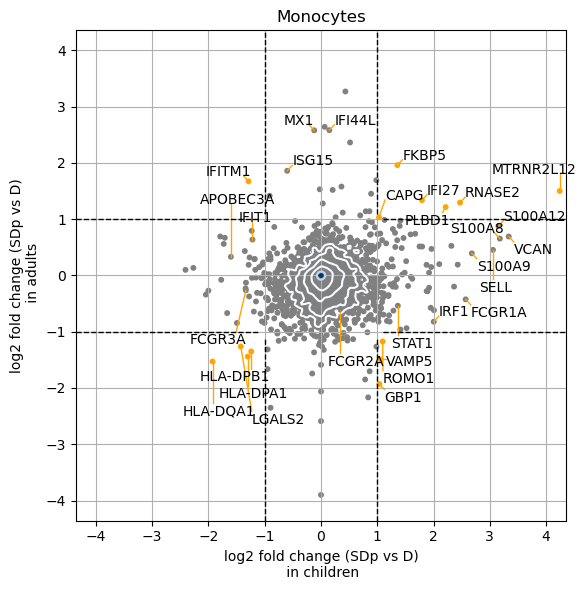

In [22]:
fig, ax = plot_scatter(all_stats2, ct=ct, figsize=[6,6])

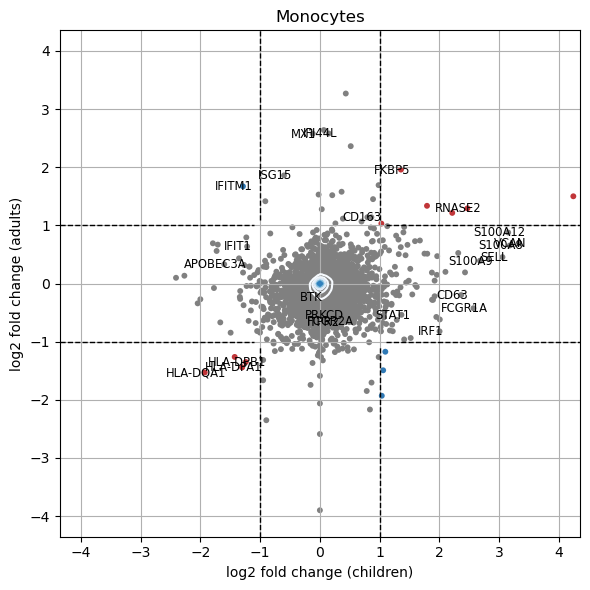

In [15]:
fig, ax = plot_scatter(all_stats2, ct=[ct], figsize=[6,6])

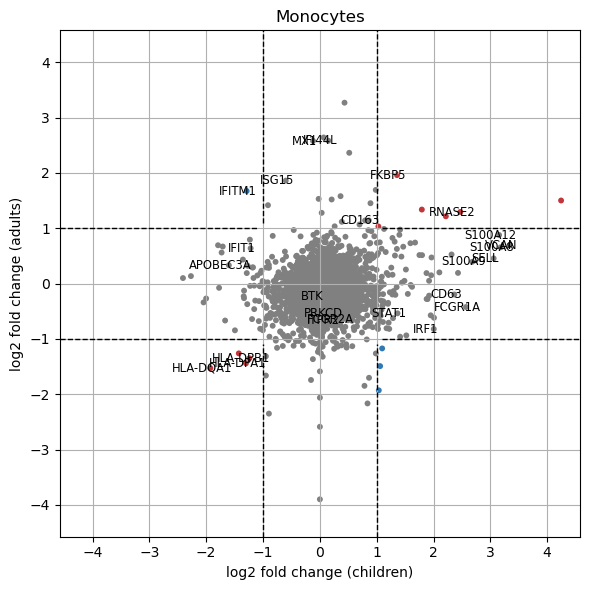

In [12]:
fig, ax = plot_scatter(all_stats2, ct=[ct], figsize=[6,6])

In [1]:
def boxplot_from_log2FC(log2FCs, title='all_cell_types', xlim=3, cbar_label= 'log2 fold change \n(SDp vs D, adults)', height=5, aspect = 0.5, vmin=-1.5, vmax = 1.5):
    import matplotlib as mpl
    from matplotlib.patches import Ellipse
    fig, ax = plt.subplots(figsize=[height*aspect, height])
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    palette = [cmap(norm(x)) for x in np.clip(log2FCs.median(axis=0), vmin, vmax)]
    sns.boxplot(data=log2FCs, orient="h", ax=ax, palette=palette)
    ax.set_title(title)
    ax.set_xlim(xlim*-1, xlim)
    ax.tick_params(labelsize=12)
    #ax.set_xticks([str(x) for x in np.linspace(vmin,vmax,1)])
    for x in [-1, 0, 1]:
        ax.axvline(x, c='black', ls='-.', lw=0.5, zorder=0.5)
    
    ax_cb = fig.add_axes([0.15, 0.04, 0.65, 0.02])
    cbar = mpl.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks(list(range(vmin, vmax+1, 1)))
    cbar.set_ticklabels([str(x) for x in list(range(vmin, vmax+1, 1))])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label)

    return fig, ax

In [4]:
df = pd.read_csv(save_tables+'DEGs_SD_vs_D_medpair_raw.csv', sep='\t', index_col=['cell_type', 'SD', 'D'])
df2 = pd.read_csv(save_tables+'DEGs_SD_vs_D_medpair_raw_adata_kid.csv', sep='\t', index_col=['cell_type', 'SD', 'D'])
df

MIR1302-2HG  AL627309.1  AL627309.3  \
cell_type    SD       D                                               
T cells      1_001_1  1-056-01         -0.0   -0.000775   -0.000000   
                      1-172-01         -0.0    0.002664   -0.000000   
                      1_003_1          -0.0   -0.002036   -0.000000   
                      1_053_01         -0.0   -0.002092   -0.000000   
                      1_183_01         -0.0   -0.003052   -0.000000   
...                                     ...         ...         ...   
Plasmablasts 5_049_01 1-056-01         -0.0    0.014108   -0.000000   
                      1-172-01         -0.0    0.014108   -0.000000   
                      1_003_1          -0.0    0.014108   -0.000000   
                      1_053_01         -0.0    0.014108   -0.000000   
                      1_183_01         -0.0    0.000939   -0.004871   

                                AL627309.5  AP006222.2  LINC01409    FAM87B  \
cell_type    SD       D                                                       
T cells      1_001_1  1-056-01    0.006821    0.002319  -0.071665  0.005610   
                      1-172-01    0.013692    0.002319  -0.228647  0.005610   
                      1_003_1     0.010258    0.001213   0.064085  0.003774   
                      1_053_01    0.008426    0.002319   0.010987  0.001376   
                      1_183_01    0.013692    0.002319   0.053660  0.005610   
...                                    ...         ...        ...       ...   
Plasmablasts 5_049_01 1-056-01    0.004625   -0.000000  -0.741956  0.006371   
                      1-172-01   -0.011876   -0.000000  -0.573912  0.006371   
                      1_003_1     0.004625   -0.000000  -0.185919  0.006371   
                      1_053_01    0.004625   -0.000000  -0.903702  0.006371   
                      1_183_01   -0.010360   -0.000000  -0.014128  0.006371   

                                LINC01128  LINC00115    FAM41C  ...  Hu.KLRG1  \
cell_type    SD       D                                         ...             
T cells      1_001_1  1-056-01  -0.187806   0.014726 -0.035976  ...  0.300004   
                      1-172-01   0.058960   0.055787 -0.013351  ...  0.332528   
                      1_003_1    0.014494   0.046841 -0.003099  ...  0.082075   
                      1_053_01   0.017576   0.049222 -0.023265  ... -0.120091   
                      1_183_01  -0.012772   0.043543 -0.013706  ...  0.237018   
...                                   ...        ...       ...  ...       ...   
Plasmablasts 5_049_01 1-056-01   0.047097  -0.125742  0.051741  ...  0.225208   
                      1-172-01  -0.225022  -0.118582  0.007818  ...  0.217744   
                      1_003_1    0.410411   0.045389  0.051741  ... -0.060537   
                      1_053_01   0.410411   0.045389  0.051741  ...  0.085800   
                      1_183_01  -0.195348  -0.029825  0.012127  ... -0.098861   

                                Hu.LOX.1  Hu.TCR.AB  Hu.TCR.Va7.2  Hu.TCR.Vd2  \
cell_type    SD       D                                                         
T cells      1_001_1  1-056-01  0.057922  -0.393414      0.019865    0.083458   
                      1-172-01  0.163286  -0.297163      0.000665   -0.031129   
                      1_003_1  -0.017809  -0.024375      0.015815   -0.028206   
                      1_053_01  0.084786  -0.327794      0.028664   -0.020447   
                      1_183_01  0.008039  -0.125801      0.002962   -0.012571   
...                                  ...        ...           ...         ...   
Plasmablasts 5_049_01 1-056-01 -0.000331   0.059436     -0.003171    0.091618   
                      1-172-01  0.048004   0.038804      0.041756    0.111381   
                      1_003_1   0.005592  -0.117486      0.035111   -0.025735   
                      1_053_01 -0.075715  -0.077855     -0.050546   -0.025319   
                      1_183_01 -0.061733  -0.021263   

In [5]:
def boxplots_from_log2FC(log2FCs, log2FCs2, title='all_cell_types', xlim=3, cbar_label= 'log2 fold change \n(SDp vs D)', height=5, aspect = 0.5, vmin=-1.5, vmax = 1.5):
    import matplotlib as mpl
    fig, axs = plt.subplots(1, 2, sharey=True,  figsize=[height*aspect, height],)
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    df=pd.concat([log2FCs, log2FCs2])
    palette = [cmap(norm(x)) for x in np.clip(log2FCs.median(axis=0), vmin, vmax)]    
    sns.boxplot(data=log2FCs, orient="h", ax=axs[0], palette=palette)
    axs[0].set_xlim(xlim*-1, xlim)
    axs[0].tick_params(labelsize=12)
    for x in [-1, 0, 1]:
        axs[0].axvline(x, c='black', ls='-.', lw=0.5, zorder=0.5)
    axs[0].set_title('adults')
    
    palette = [cmap(norm(x)) for x in np.clip(log2FCs2.median(axis=0), vmin, vmax)]    
    sns.boxplot(data=log2FCs2, orient="h", ax=axs[1], palette=palette)
    axs[1].set_xlim(xlim*-1, xlim)
    axs[1].tick_params(labelsize=12)
    for x in [-1, 0, 1]:
        axs[1].axvline(x, c='black', ls='-.', lw=0.5, zorder=0.5)
    axs[1].set_title('children')
    
    ax_cb = fig.add_axes([0.25, 0.02, 0.5, 0.02])
    cbar = mpl.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks(list(range(vmin, vmax+1, 1)))
    cbar.set_ticklabels([str(x) for x in list(range(vmin, vmax+1, 1))])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label)
    
    #fig.suptitle(title)

    plt.subplots_adjust(wspace=0.3, hspace=0)
    
    return fig, axs


In [20]:
genes = ['FKBP5', 'RNASE2', 'FCGR1A', 
         'S100A8', 'S100A9', 'S100A12', 'VCAN', 'SELL', 'CD63', 
         #'CD163', 
         #'MTRNR2L12','PLBD1', 'CAPG', 
         #'FCGR2A', 'FCGR3A', #'PRKCD', 'BTK', 'ITPR2', 
         #'BANF1', 
         'IFNAR1', 'IFNAR2', 'TYK2', 'JAK1',
         'IFNGR1', 'IFNGR2', 'JAK2', 'JAK3',
         'STAT1', 'STAT2', 'IRF1', 'IRF9', 
         #'GBP1', 
         'IFIT1', 'ISG15', 'APOBEC3A', 'MX1', 'IFITM1', 'IFI44L', 'IFI6', #'IFI27', 
         'HLA-DPB1', 'HLA-DPA1', 'HLA-DQA1', 'HLA-DRA', 'HLA-A', 'HLA-E',
         #'LGALS2', 'ROMO1', 'VAMP5', 
          
        ]

# PLBD1: CD14+ classical monocytes markers, antimicrobial activity
# S100A8, 'S100A9', 'S100A12',: proinflammatory activity
# ROMO1: oxidative stress
# LGALS2: oxidative stress
# VAMP5: trafficking (SNARE)



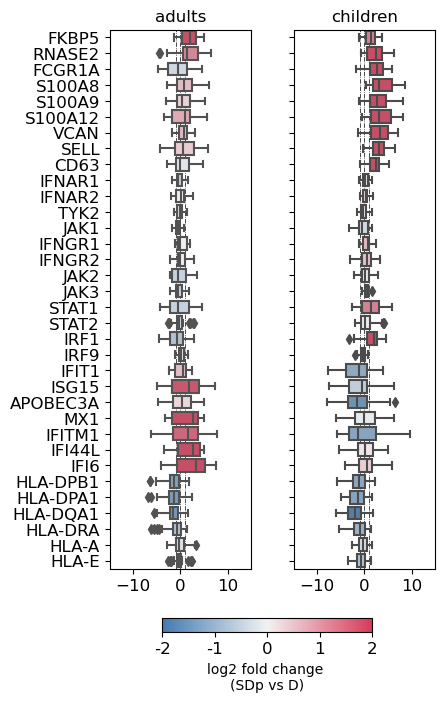

In [21]:
ct = 'Monocytes'
fig, ax = boxplots_from_log2FC(df.loc[ct][genes], df2.loc[ct][genes], vmin=-2, vmax=2,
                              title=ct, xlim=15,
                              height=7, aspect = 0.6, 
                              #cbar_label= f'log2 fold change \nVHCs vs {cond}\n{samp}\n{cts}',
                             )
plt.show()


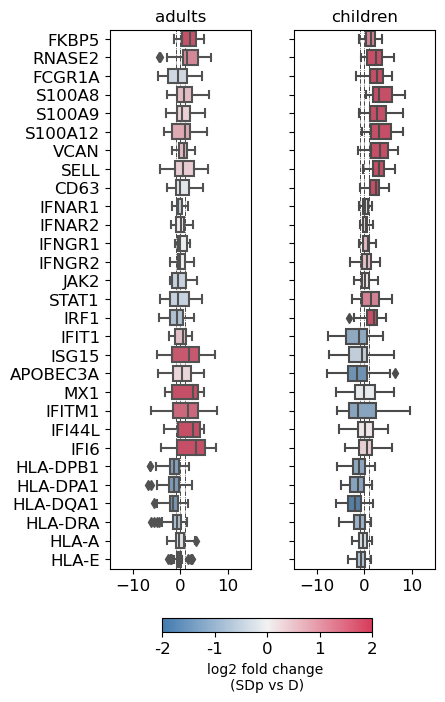

In [23]:
genes = ['FKBP5', 'RNASE2', 'FCGR1A', 
         'S100A8', 'S100A9', 'S100A12', 'VCAN', 'SELL', 'CD63', 
         #'CD163', 
         #'MTRNR2L12','PLBD1', 'CAPG', 
         #'FCGR2A', 'FCGR3A', #'PRKCD', 'BTK', 'ITPR2', 
         #'BANF1', 
         'IFNAR1', 'IFNAR2', #'TYK2', 'JAK1',
         'IFNGR1', 'IFNGR2', 'JAK2', #'JAK3',
         'STAT1', #'STAT2', 
         'IRF1', #'IRF9', 
         #'GBP1', 
         'IFIT1', 'ISG15', 'APOBEC3A', 'MX1', 'IFITM1', 'IFI44L', 'IFI6', #'IFI27', 
         'HLA-DPB1', 'HLA-DPA1', 'HLA-DQA1', 'HLA-DRA', 'HLA-A', 'HLA-E',
         #'LGALS2', 'ROMO1', 'VAMP5', 
          
        ]
ct = 'Monocytes'
fig, ax = boxplots_from_log2FC(df.loc[ct][genes], df2.loc[ct][genes], vmin=-2, vmax=2,
                              title=ct, xlim=15,
                              height=7, aspect = 0.6, 
                              #cbar_label= f'log2 fold change \nVHCs vs {cond}\n{samp}\n{cts}',
                             )
plt.show()


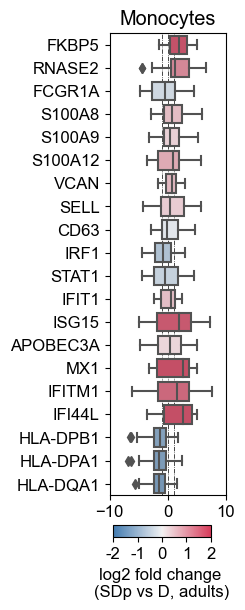

In [30]:
fig, ax = boxplot_from_log2FC(df.loc[ct][genes[:-5]], vmin=-2, vmax=2,
                              title=ct, xlim=10,
                              height=6, aspect = 0.25, 
                              #cbar_label= f'log2 fold change \nVHCs vs {cond}\n{samp}\n{cts}',
                             )
plt.show()


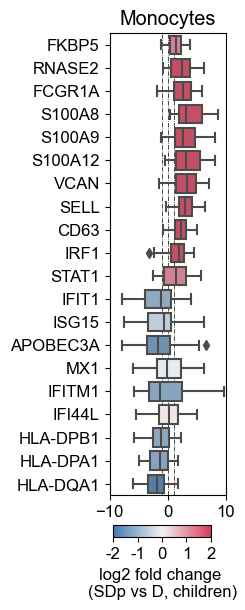

In [31]:
fig, ax = boxplot_from_log2FC(df2.loc[ct][genes[:-5]], vmin=-2, vmax=2,
                              title=ct, xlim=10,
                              height=6, aspect = 0.25, 
                              cbar_label= 'log2 fold change \n(SDp vs D, children)',
                             )
plt.show()


In [10]:
df = pd.read_csv(save_tables+'DEGs_SD_vs_D_medpair_raw.csv', sep='\t', index_col=['cell_type', 'SD', 'D'])
df2 = pd.read_csv(save_tables+'DEGs_SD_vs_D_medpair_raw_adata_kid.csv', sep='\t', index_col=['cell_type', 'SD', 'D'])
genes = ['FCGR1A', 'FCGR2A', 'PRKCD', 'BTK', 'ITPR2', 'CD163']

In [11]:
def radar_plot(df1=df, df2=df2, groups=['adults', 'children'], figsize=(6,6), rcircle=3.2, genes=['genes'], ct='NK cells', name=''):
    angles=np.linspace(0,2*np.pi,len(genes), endpoint=False)
    angles=np.concatenate((angles,[angles[0]]))

    rcParams['font.size']=12
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    rcParams['figure.dpi'] = 100

    fig= plt.figure(figsize=figsize)
    ax = fig.add_subplot(polar=True)
    
    colors = [(0.9058823529411765, 0.5411764705882353, 0.7647058823529411), 
             (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)]

    categories = [*genes, genes[0]]
    children = df1.loc[ct].loc[categories]
    adults = df2.loc[ct].loc[categories]
    ax.plot(angles, children, label=groups[0],color=colors[0], linewidth=2,)
    ax.plot(angles, adults, label=groups[1],color=colors[1], linewidth=2,)
        
    ax.grid(True, ls='--', zorder=-5, lw=0.5)
    circle = plt.Circle((0, 0), rcircle, transform=ax.transData._b, edgecolor="k", 
                        fill=False, lw=1)
    ax.add_artist(circle)
    ax.set_rticks([-3, -2, -1, 0, 1, 2, 3])

    ax.set_thetagrids(angles * 180/np.pi, genes + [genes[0]])
    ax.set_xlabel('log2 fold change (SDp vs D)')
    ax.set_title(name.replace('_', ' '))
    
    plt.title(ct, size=20, y=1.1)
    plt.tight_layout()
    plt.legend(bbox_to_anchor=[1.5, 1])
    
    return {'fig': fig, 'ax': ax}

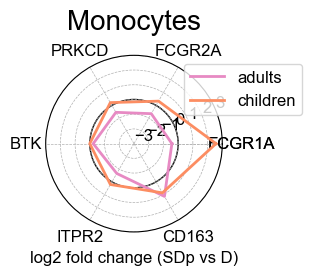

In [15]:
fig = radar_plot(df1=df_adult, df2=df_kid, figsize=(3,3), rcircle=3.,
                 genes=genes, ct=ct)['fig']
fig.savefig(save_figures + f'radarplot_{ct}_fcgr.svg', bbox_inches='tight', dpi=300)

In [17]:
all_stats2.loc['CD163']

adata_kid                 0.86169
adata_adult              1.140358
DEG            upregulated_either
r                        1.429309
r2                       2.042925
distance                 0.197048
Name: CD163, dtype: object